In [1]:
import os
import glob
import pandas as pd
import numpy as np
import xarray as xr
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Ρυθμίσεις εμφάνισης
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
%matplotlib inline

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [2]:
def load_region_data(root_path, region_name):
    """
    Φορτώνει δεδομένα διορθώνοντας αυτόματα το θέμα με τους διπλούς φακέλους.
    """
    print(f"\n--- 🔍 Loading Data for {region_name} ---")

    # 1. Εντοπισμός του σωστού Path
    base_path = os.path.join(root_path, region_name)

    # Βγάζουμε το "μικρό" όνομα (π.χ. από το WR1-2025... κρατάμε το WR1)
    short_name = region_name.split('-')[0]

    # Ελέγχουμε αν υπάρχει υποφάκελος "WR1" μέσα στον μεγάλο φάκελο
    nested_path = os.path.join(base_path, short_name)

    if os.path.exists(nested_path):
        region_path = nested_path
        print(f"📂 Detected nested folder. Entering: .../{short_name}")
    else:
        region_path = base_path
        print(f"📂 Using base folder: .../{region_name}")

    temp_folder = os.path.join(region_path, "OCEAN_TEMPERATURE")
    mld_folder = os.path.join(region_path, "MIXED_LAYER_DEPTH")

    # 2. Φόρτωση Ατμοσφαιρικών (CSV)
    # Ψάχνουμε γενικά για *ATMOSPHERIC*.csv για να δουλεύει και στο WR1 και στο WR2 κλπ
    atmos_files = glob.glob(os.path.join(region_path, "*ATMOSPHERIC*.csv"))

    if atmos_files:
        print(f"✅ Found Atmos File: {os.path.basename(atmos_files[0])}")
        try:
            # Δοκιμάζουμε να διαβάσουμε την ημερομηνία
            df_atmos = pd.read_csv(atmos_files[0])

            # Βρίσκουμε ποια στήλη είναι η ημερομηνία (συνήθως 'time' ή η πρώτη στήλη)
            if 'time' in df_atmos.columns:
                date_col = 'time'
            else:
                date_col = df_atmos.columns[0]

            df_atmos[date_col] = pd.to_datetime(df_atmos[date_col])
            df_atmos.set_index(date_col, inplace=True)
            df_atmos = df_atmos.resample('D').mean()

        except Exception as e:
            print(f"⚠️ Error reading CSV: {e}")
            df_atmos = pd.DataFrame()
    else:
        print(f"❌ Warning: No Atmospheric CSV found in {region_path}")
        df_atmos = pd.DataFrame()

    # 3. Φόρτωση Ωκεανογραφικών (.nc)
    print("⏳ Loading Ocean Temperature .nc files...")
    nc_files_temp = glob.glob(os.path.join(temp_folder, "*.nc"))

    if not nc_files_temp:
        print(f"❌ Error: No .nc files found in {temp_folder}")
        df_ocean = pd.DataFrame()
    else:
        try:
            ds_temp = xr.open_mfdataset(os.path.join(temp_folder, "*.nc"), combine='by_coords', parallel=True)

            # Spatial Averaging
            spatial_dims = [d for d in ds_temp.dims if d not in ['time', 'depth', 'lev', 'level']]
            ds_temp = ds_temp.mean(dim=spatial_dims)

            temp_var = list(ds_temp.data_vars)[0]

            # Target Temp (0-20m)
            temp_surf = ds_temp[temp_var].sel(depth=slice(0, 20)).mean(dim='depth').to_series().rename("temp_0_20m")
            # Deep Temp (20-200m)
            temp_deep = ds_temp[temp_var].sel(depth=slice(20, 200)).mean(dim='depth').to_series().rename("temp_20_200m")

            df_ocean = pd.concat([temp_surf, temp_deep], axis=1)
            print(f"✅ Ocean Temp loaded. Rows: {len(df_ocean)}")
        except Exception as e:
            print(f"❌ Error processing Ocean Temp: {e}")
            df_ocean = pd.DataFrame()

    # 4. Φόρτωση MLD (.nc)
    print("⏳ Loading MLD .nc files...")
    nc_files_mld = glob.glob(os.path.join(mld_folder, "*.nc"))

    if not nc_files_mld:
        print(f"❌ Error: No .nc files found in {mld_folder}")
        df_mld = pd.DataFrame()
    else:
        try:
            ds_mld = xr.open_mfdataset(os.path.join(mld_folder, "*.nc"), combine='by_coords', parallel=True)
            spatial_dims_mld = [d for d in ds_mld.dims if d not in ['time', 'depth']]
            ds_mld = ds_mld.mean(dim=spatial_dims_mld)

            mld_var = list(ds_mld.data_vars)[0]
            df_mld = ds_mld[mld_var].to_series().rename("mld")
            print(f"✅ MLD loaded. Rows: {len(df_mld)}")
        except Exception as e:
            print(f"❌ Error processing MLD: {e}")
            df_mld = pd.DataFrame()

    # 5. Merge
    print("🔄 Merging datasets...")
    if df_ocean.empty:
        print("❌ Critical Error: Ocean data is empty.")
        return pd.DataFrame()

    master_df = pd.merge(df_ocean, df_mld, left_index=True, right_index=True, how='inner')

    if not df_atmos.empty:
        master_df = pd.merge(master_df, df_atmos, left_index=True, right_index=True, how='left')

    # Final cleanup
    master_df = master_df.resample('D').mean().interpolate(method='linear')

    print(f"🎉 Success! Final Dataset Shape: {master_df.shape}")
    return master_df

In [3]:
# --- ΟΡΙΣΜΟΣ ΤΗΣ ΣΥΝΑΡΤΗΣΗΣ ---
def create_features(data, forecast_days=7):
    df_feat = data.copy()

    # 1. Climatology (Το όριο για τον καύσωνα - 90th Percentile)
    # Υπολογίζουμε το 90% για κάθε μέρα του χρόνου (1-366)
    if not df_feat.empty:
        climatology = df_feat.groupby(df_feat.index.dayofyear)['temp_0_20m'].quantile(0.90)
        df_feat['dayofyear'] = df_feat.index.dayofyear
        df_feat['mhw_threshold'] = df_feat['dayofyear'].map(climatology)
    else:
        return pd.DataFrame(), pd.Series()

    # 2. Physics Lags (Η ιστορία επηρεάζει το μέλλον)
    cols_to_lag = ['temp_0_20m', 'temp_20_200m', 'mld', 'wind_speed']
    for col in cols_to_lag:
        if col in df_feat.columns:
            df_feat[f'{col}_lag1'] = df_feat[col].shift(1)  # Χθεσινή τιμή
            df_feat[f'{col}_mean7'] = df_feat[col].rolling(7).mean()  # Μέσος όρος εβδομάδας

    # 3. Target: Πρόβλεψη για το μέλλον (π.χ. σε 7 μέρες)
    df_feat['target_future_temp'] = df_feat['temp_0_20m'].shift(-forecast_days)

    return df_feat.dropna(), climatology

# --- 🕵️‍♂️ DEBUGGING BLOCK (ΕΚΤΕΛΕΣΗ) ---
print("\n--- DATA HEALTH CHECK ---")

# 1. Έλεγχος αν υπάρχει το df
if 'df' not in locals():
    print("❌ ERROR: Η μεταβλητή 'df' δεν υπάρχει. Τρέξε πρώτα τη φόρτωση δεδομένων!")
else:
    # 2. Έλεγχος μεγέθους και ημερομηνιών
    print(f"Total Rows in initial df: {len(df)}")

    if not df.empty:
        print(f"Start Date: {df.index.min()}")
        print(f"End Date:   {df.index.max()}")

        # 3. Έλεγχος για NaNs (Κενά)
        print(f"\nMissing Values (NaNs) per column:\n{df.isnull().sum()}")

        # 4. Έλεγχος μετά το καθάρισμα (create_features)
        test_feat, _ = create_features(df, forecast_days=7)
        print(f"\nRows AFTER processing (create_features & dropna): {len(test_feat)}")

        if test_feat.empty:
            print("❌ CRITICAL: Ο καθαρισμός (dropna) έσβησε ΟΛΑ τα δεδομένα!")
            print("   -> Πιθανότατα κάποια στήλη (π.χ. MLD ή Wind) έχει μόνο κενά.")
        else:
            print(f"✅ Ready for Training! Valid Dates: {test_feat.index.min()} έως {test_feat.index.max()}")

            # Έλεγχος ημερομηνίας split
            test_year = 2022
            if test_feat.index.max().year < test_year:
                print(f"⚠️ WARNING: Τα δεδομένα σου τελειώνουν το {test_feat.index.max().year}. ")
                print(f"   Πρέπει να αλλάξεις το split_date σε κάτι πιο παλιό (π.χ. {test_feat.index.max().year - 1})")
    else:
        print("❌ CRITICAL: Το αρχικό DataFrame 'df' είναι άδειο!")

print("-------------------------")


--- DATA HEALTH CHECK ---
❌ ERROR: Η μεταβλητή 'df' δεν υπάρχει. Τρέξε πρώτα τη φόρτωση δεδομένων!
-------------------------


In [4]:
# --- ΒΗΜΑ ΕΚΤΕΛΕΣΗΣ ---

# 1. Ορίζουμε ξανά τα paths (για σιγουριά)
ROOT_PATH = r"C:\Users\panos\PycharmProjects\PythonProject"
REGION = "WR1-20251125T132713Z-1-001"

print(f"🚀 Ξεκινάω τη φόρτωση για: {REGION}")

# 2. ΚΑΛΟΥΜΕ τη συνάρτηση (Αυτό είναι το βήμα που έλειπε)
df = load_region_data(ROOT_PATH, REGION)

# 3. Ελέγχουμε το αποτέλεσμα
if not df.empty:
    print("\n✅ ΕΠΙΤΥΧΙΑ! Δες τις πρώτες 5 γραμμές:")
    print(df.head()) # Τυπώνει τα δεδομένα

    # 4. Γρήγορο γράφημα για να βεβαιωθούμε ότι έχουμε νούμερα
    df[['temp_0_20m', 'mld']].plot(subplots=True, figsize=(10, 6), title="Προεπισκόπηση Δεδομένων")
    plt.show()
else:
    print("\n❌ Το DataFrame είναι άδειο. Κάτι πήγε στραβά με τα αρχεία.")

🚀 Ξεκινάω τη φόρτωση για: WR1-20251125T132713Z-1-001

--- 🔍 Loading Data for WR1-20251125T132713Z-1-001 ---
📂 Detected nested folder. Entering: .../WR1
✅ Found Atmos File: ATMOSPHERIC_DATA_WR1_1985_2023.csv
⚠️ Error reading CSV: No columns to parse from file
⏳ Loading Ocean Temperature .nc files...
❌ Error processing Ocean Temp: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
⏳ Loading MLD .nc files...
❌ Error processing MLD: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://d

Searching for data files...
Found Aquaculture File: .\Data\WR1\AQUACULTURE_WR1.xlsx
Aquaculture Data Loaded:
          Date            Species  Av_Temp  Mortality(#)
648 2015-05-15  Conventional Bass     19.0         851.0
783 2015-05-15       Organic Bass     19.0           0.0
784 2015-06-15       Organic Bass     21.0         145.0
649 2015-06-15  Conventional Bass     21.0        3318.0
31  2015-06-15      Organic bream     21.0        2950.0
MHW Temperature Threshold (90th percentile): 25.00 °C

Training MHW Early Warning Model...
MHW Prediction Accuracy: 0.87
Training Impact Assessment Model...


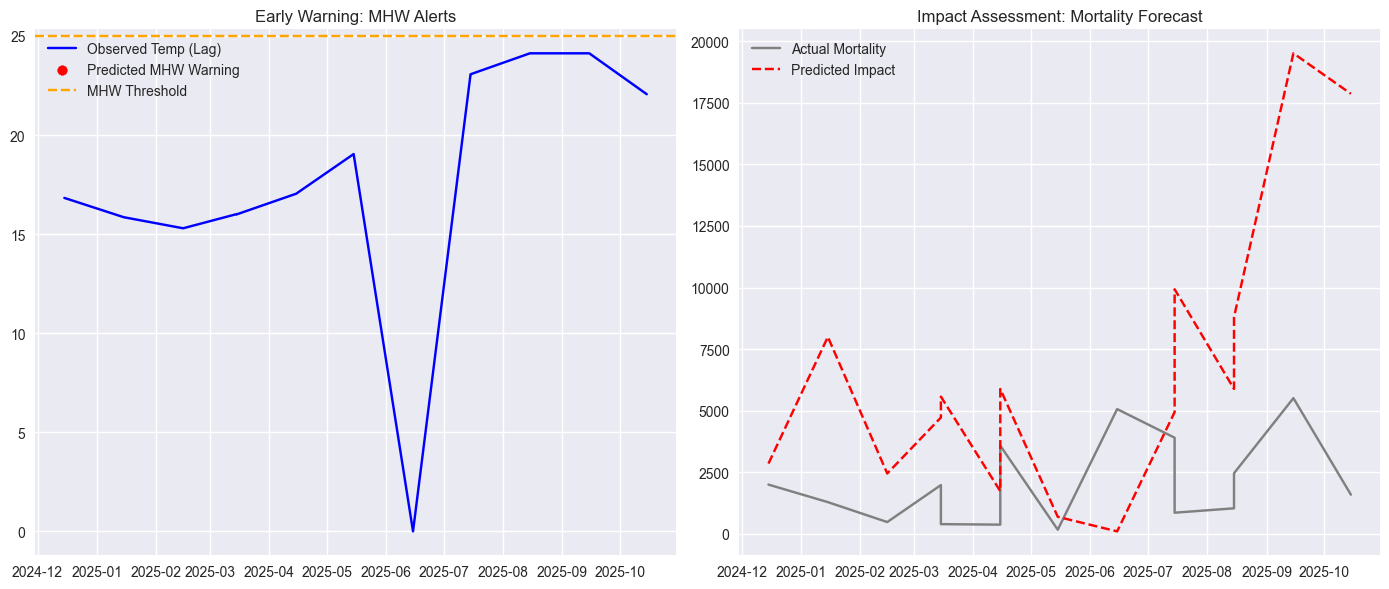


   MARINE HEATWAVE EARLY WARNING SYSTEM
Current Date: 2025-10-15
MHW Probability (Next Period): 2.0%
Predicted Impact (Mortality):  17866 fish
STATUS: Normal Conditions


In [5]:
import xarray as xr
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import os
import glob
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

# --- 1. ROBUST PATH FINDER ---
def find_data_path(filename_pattern, root_dir="."):
    """Recursively finds files matching the pattern."""
    matches = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if filename_pattern in file or (filename_pattern in root):
                matches.append(os.path.join(root, file))
    return matches

print("Searching for data files...")
# Adjust patterns based on your specific folder names (WR4, SR1, etc.)
aqua_files = find_data_path("AQUACULTURE_WR1.xlsx")
ocean_files = find_data_path(".nc") # Finds all NetCDF files

if not aqua_files:
    raise FileNotFoundError("Aquaculture Excel file not found!")
print(f"Found Aquaculture File: {aqua_files[0]}")

# --- 2. LOAD AQUACULTURE DATA (IMPACT) ---
df_aqua = pd.read_excel(aqua_files[0])

# Create a clear Date column
# Assuming 'Year' and 'Month' exist based on file snippet
df_aqua['Day'] = 15 # Assume mid-month for monthly data
df_aqua['Date'] = pd.to_datetime(df_aqua[['Year', 'Month', 'Day']])
df_aqua = df_aqua.sort_values('Date')

print("Aquaculture Data Loaded:")
print(df_aqua[['Date', 'Species', 'Av_Temp', 'Mortality(#)']].head())

# --- 3. MARINE HEATWAVE (MHW) DEFINITION ---
# Definition: Temp > 90th percentile of climatology for at least 5 days
# We calculate the 90th percentile threshold from the site's history
threshold = df_aqua['Av_Temp'].quantile(0.90)
print(f"MHW Temperature Threshold (90th percentile): {threshold:.2f} °C")

# Label historical MHWs in the dataset
df_aqua['is_MHW'] = (df_aqua['Av_Temp'] > threshold).astype(int)

# --- 4. BUILD EARLY WARNING MODEL (FORECAST) ---
# Goal: Predict if next month/period will be a MHW based on current conditions
# Features: Lagged Temperature, Month, seasonality
df_aqua['Temp_Lag1'] = df_aqua['Av_Temp'].shift(1) # Previous month
df_aqua['Temp_Lag2'] = df_aqua['Av_Temp'].shift(2)
df_aqua['Mortality_Lag1'] = df_aqua['Mortality(#)'].shift(1)

# Drop NaN from shifts
model_data = df_aqua.dropna().copy()

# FEATURES and TARGET
X = model_data[['Temp_Lag1', 'Temp_Lag2', 'Month', 'Mortality_Lag1']]
y_mhw = model_data['is_MHW'] # Classification: Will it be a MHW?
y_impact = model_data['Mortality(#)'] # Regression: How many fish will die?

# Train/Test Split
X_train, X_test, y_mhw_train, y_mhw_test, y_imp_train, y_imp_test = train_test_split(
    X, y_mhw, y_impact, test_size=0.2, shuffle=False
)

# --- 5. TRAIN XGBOOST MODELS ---

# A. MHW Onset Predictor (Classifier)
print("\nTraining MHW Early Warning Model...")
clf_mhw = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, eval_metric='logloss')
clf_mhw.fit(X_train, y_mhw_train)
mhw_preds = clf_mhw.predict(X_test)
print(f"MHW Prediction Accuracy: {accuracy_score(y_mhw_test, mhw_preds):.2f}")

# B. Impact Predictor (Regressor)
print("Training Impact Assessment Model...")
reg_impact = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05)
reg_impact.fit(X_train, y_imp_train)
impact_preds = reg_impact.predict(X_test)

# --- 6. VISUALIZE EARLY WARNING SYSTEM OUTPUT ---
plt.figure(figsize=(14, 6))

# Plot 1: Temperature & MHW Alerts
plt.subplot(1, 2, 1)
plt.plot(model_data['Date'].iloc[-len(y_mhw_test):], X_test['Temp_Lag1'], label='Observed Temp (Lag)', color='blue')
plt.scatter(model_data['Date'].iloc[-len(y_mhw_test):][mhw_preds==1],
            X_test['Temp_Lag1'][mhw_preds==1],
            color='red', label='Predicted MHW Warning', zorder=5)
plt.axhline(threshold, color='orange', linestyle='--', label='MHW Threshold')
plt.title("Early Warning: MHW Alerts")
plt.legend()

# Plot 2: Predicted Impact (Mortality)
plt.subplot(1, 2, 2)
plt.plot(model_data['Date'].iloc[-len(y_imp_test):], y_imp_test, label='Actual Mortality', color='grey')
plt.plot(model_data['Date'].iloc[-len(y_imp_test):], impact_preds, label='Predicted Impact', color='red', linestyle='--')
plt.title("Impact Assessment: Mortality Forecast")
plt.legend()

plt.tight_layout()
plt.show()

# --- 7. GENERATE WARNING REPORT ---
latest_data = X.iloc[[-1]] # The most recent data point
prob_mhw = clf_mhw.predict_proba(latest_data)[0][1]
pred_mortality = reg_impact.predict(latest_data)[0]

print("\n" + "="*40)
print("   MARINE HEATWAVE EARLY WARNING SYSTEM")
print("="*40)
print(f"Current Date: {model_data.iloc[-1]['Date'].strftime('%Y-%m-%d')}")
print(f"MHW Probability (Next Period): {prob_mhw*100:.1f}%")
print(f"Predicted Impact (Mortality):  {int(pred_mortality)} fish")
status = "CRITICAL ALERT" if prob_mhw > 0.5 else "Normal Conditions"
print(f"STATUS: {status}")
print("="*40)

In [6]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

# --- 1. ΕΥΡΕΣΗ ΑΡΧΕΙΩΝ ---
def find_file(pattern, root_dir="."):
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if pattern in file:
                return os.path.join(root, file)
    return None

print("Αναζήτηση αρχείων...")
aqua_file = find_file("AQUACULTURE_WR1.xlsx")
wind_csv = find_file("ATMOSPHERIC_DATA_WR1") # Ψάχνουμε το CSV που ανέφερες

if not aqua_file:
    raise FileNotFoundError("Δεν βρέθηκε το αρχείο AQUACULTURE_WR1.xlsx!")
if not wind_csv:
    raise FileNotFoundError("Δεν βρέθηκε το αρχείο ATMOSPHERIC CSV!")

print(f"Loading Aquaculture: {aqua_file}")
print(f"Loading Atmospheric: {wind_csv}")

# --- 2. ΕΠΕΞΕΡΓΑΣΙΑ ΑΤΜΟΣΦΑΙΡΙΚΩΝ ΔΕΔΟΜΕΝΩΝ (CSV) ---
# Διαβάζουμε το CSV (Άνεμος, Air Temp, Radiation)
df_atmos = pd.read_csv(wind_csv)

# Μετατροπή της στήλης 'time' σε ημερομηνία
# Προσοχή: Το dayfirst=True είναι σημαντικό για μορφές DD-MM-YY
df_atmos['time'] = pd.to_datetime(df_atmos['time'], dayfirst=True)

# Κάνουμε Resample σε Μηνιαία βάση (Month Start) παίρνοντας τον Μέσο Όρο
# Η ιχθυοκαλλιέργεια έχει 1 μέτρηση το μήνα, το CSV έχει ανά 3 ώρες.
df_atmos_monthly = df_atmos.set_index('time').resample('MS').mean()

# Κρατάμε μόνο ότι μας ενδιαφέρει (π.χ. Windspeed, 2m-air Temperature)
df_features = df_atmos_monthly[['Windspeed', '2m-air Temperature']].copy()
df_features.columns = ['Wind_Speed', 'Air_Temp'] # Μετονομασία για ευκολία

# --- 3. ΕΠΕΞΕΡΓΑΣΙΑ AQUACULTURE DATA ---
df_aqua = pd.read_excel(aqua_file)

# Δημιουργία ημερομηνίας (υποθέτουμε 1η του μήνα για να ταιριάξει με το 'MS' του CSV)
df_aqua['Day'] = 1
df_aqua['Date'] = pd.to_datetime(df_aqua[['Year', 'Month', 'Day']])
df_aqua = df_aqua.sort_values('Date').set_index('Date')

# --- 4. ΣΥΓΧΩΝΕΥΣΗ (MERGE) ---
# Ενώνουμε τα δύο DataFrames βάσει της ημερομηνίας (Index)
df_final = df_aqua.join(df_features, how='inner')

print(f"Τελικό Dataset: {df_final.shape[0]} μήνες κοινών δεδομένων.")

# --- 5. ΠΡΟΕΤΟΙΜΑΣΙΑ ΜΟΝΤΕΛΟΥ (EARLY WARNING) ---

# Ορισμός MHW (Θερμοκρασία Νερού > 90th percentile)
threshold = df_final['Av_Temp'].quantile(0.90)
df_final['is_MHW'] = (df_final['Av_Temp'] > threshold).astype(int)

# LAGS: Χρησιμοποιούμε δεδομένα του ΠΡΟΗΓΟΥΜΕΝΟΥ μήνα για να προβλέψουμε τον ΕΠΟΜΕΝΟ
df_final['Water_Temp_Lag1'] = df_final['Av_Temp'].shift(1)
df_final['Wind_Lag1'] = df_final['Wind_Speed'].shift(1)       # <-- Ο Άνεμος ως προγνωστικό
df_final['Air_Temp_Lag1'] = df_final['Air_Temp'].shift(1)     # <-- Θερμοκρασία Αέρα
df_final['Mortality_Lag1'] = df_final['Mortality(#)'].shift(1)

# Αφαίρεση κενών (λόγω shift)
model_data = df_final.dropna()

# Επιλογή Χαρακτηριστικών (Features) και Στόχου (Target)
features = ['Water_Temp_Lag1', 'Wind_Lag1', 'Air_Temp_Lag1', 'Month', 'Mortality_Lag1']
X = model_data[features]
y_mhw = model_data['is_MHW']          # Στόχος 1: Θα γίνει καύσωνας;
y_impact = model_data['Mortality(#)'] # Στόχος 2: Επιπτώσεις (Θνησιμότητα)

# --- 6. ΕΚΠΑΙΔΕΥΣΗ (XGBoost) ---
X_train, X_test, y_mhw_train, y_mhw_test, y_imp_train, y_imp_test = train_test_split(
    X, y_mhw, y_impact, test_size=0.2, shuffle=False
)

# Μοντέλο 1: Πρόβλεψη Καύσωνα
clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, random_state=42)
clf.fit(X_train, y_mhw_train)

# Μοντέλο 2: Πρόβλεψη Επιπτώσεων
reg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
reg.fit(X_train, y_imp_train)

# --- 7. ΑΠΟΤΕΛΕΣΜΑΤΑ & FEATURE IMPORTANCE ---
# Προβλέψεις
mhw_preds = clf.predict(X_test)
print(f"\nΑκρίβεια Πρόβλεψης MHW: {accuracy_score(y_mhw_test, mhw_preds)*100:.1f}%")

# Πόσο σημαντικός ήταν τελικά ο άνεμος;
plt.figure(figsize=(10, 5))
xgb.plot_importance(clf, importance_type='weight', title='Ποιοι παράγοντες προειδοποιούν για MHW;', show_values=False)
plt.tight_layout()
plt.show()

# --- 8. REPORT ---
latest = X.iloc[[-1]]
next_prob = clf.predict_proba(latest)[0][1]
print("\n" + "="*40)
print(f"ΠΡΟΓΝΩΣΗ ΓΙΑ ΤΟΝ ΕΠΟΜΕΝΟ ΜΗΝΑ ({model_data.index[-1].strftime('%Y-%m')})")
print(f"Ταχύτητα Ανέμου (Τρέχουσα): {latest['Wind_Lag1'].values[0]:.2f} m/s")
print(f"Πιθανότητα Καύσωνα (MHW): {next_prob*100:.1f}%")
print("="*40)

Αναζήτηση αρχείων...
Loading Aquaculture: .\Data\WR1\AQUACULTURE_WR1.xlsx
Loading Atmospheric: .\Data\WR1\ATMOSPHERIC_DATA_WR1_1985_2023.csv


C:\Users\panos\AppData\Local\Temp\ipykernel_13084\1230451936.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_atmos['time'] = pd.to_datetime(df_atmos['time'], dayfirst=True)


TypeError: agg function failed [how->mean,dtype->object]

In [1]:
import pandas as pd
import os

# Βρίσκουμε το αρχείο
def find_file(pattern, root_dir="."):
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if pattern in file:
                return os.path.join(root, file)
    return None

file_path = find_file("AQUACULTURE_WR1.xlsx")

if file_path:
    df = pd.read_excel(file_path)
    print("=== ΣΤΗΛΕΣ ΑΡΧΕΙΟΥ EXCEL ===")
    print(df.columns.tolist())
    print("\n=== ΠΡΩΤΕΣ 5 ΓΡΑΜΜΕΣ ===")
    print(df.head())
else:
    print("❌ Το αρχείο AQUACULTURE_WR1.xlsx δεν βρέθηκε!")

=== ΣΤΗΛΕΣ ΑΡΧΕΙΟΥ EXCEL ===
['Year', 'Month', 'Species', 'Batch', 'Initial_Fish(#)', 'Initial_Biomass(kg)', 'Initial_AvWeight(g)', 'Final_Fish(#)', 'Final_Biomass(kg)', 'Final_AvWeight(g)', 'Input_Fish(#)', 'Harvest(#)', 'Harvest(kg)', 'Feed(kg)', 'Mortality(#)', 'Mortality_AvWt.(g)', 'Net_Transfer_In(#)', 'Econventional_FCR', 'Biol_FCR', 'Av_Temp', 'SFR', 'SGR', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33']

=== ΠΡΩΤΕΣ 5 ΓΡΑΜΜΕΣ ===
   Year  Month Species    Batch  Initial_Fish(#)  Initial_Biomass(kg)  \
0  2015      6  Meagre  ar/15/1                0               0.0000   
1  2015      7  Meagre  ar/15/1            51000             879.2400   
2  2015      8  Meagre  ar/15/1            25430            1058.6509   
3  2015      9  Meagre  ar/15/1            24830            2484.9864   
4  2015     10  Meagre  ar/15/1            19905            31

🔄 Αναζήτηση αρχείων...
📖 Φόρτωση Excel: .\Data\WR1\AQUACULTURE_WR1.xlsx
📖 Φόρτωση CSV: .\Data\WR1\ATMOSPHERIC_DATA_WR1_1985_2023.csv
✅ Επιτυχής Ένωση! 1531 μήνες δεδομένων.

🎯 Ακρίβεια Μοντέλου: 66.7%

ΠΡΟΓΝΩΣΗ ΓΙΑ: 2024-01
Θερμοκρασία Νερού (Lag): 16.1°C
Άνεμος (Lag):            4.2 m/s
----------------------------------------
Πιθανότητα Καύσωνα:      30.7%
Εκτιμώμενη Θνησιμότητα:  12352
STATUS: 🟢 ΦΥΣΙΟΛΟΓΙΚΕΣ ΣΥΝΘΗΚΕΣ


<Figure size 1000x500 with 0 Axes>

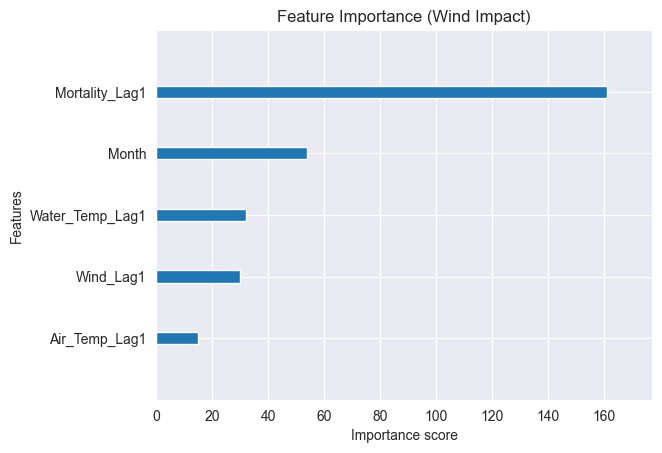

In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# --- 1. ΕΥΡΕΣΗ ΑΡΧΕΙΩΝ ---
def find_file(pattern, root_dir="."):
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if pattern in file and not file.startswith('~$'):
                return os.path.join(root, file)
    return None

print("🔄 Αναζήτηση αρχείων...")
aqua_path = find_file("AQUACULTURE_WR1.xlsx")
wind_path = find_file("ATMOSPHERIC_DATA_WR1")

if not aqua_path or not wind_path:
    raise FileNotFoundError("❌ Δεν βρέθηκαν τα αρχεία (Excel ή CSV).")

# --- 2. ΦΟΡΤΩΣΗ AQUACULTURE (EXCEL) ---
print(f"📖 Φόρτωση Excel: {aqua_path}")
df_aqua = pd.read_excel(aqua_path)
df_aqua['Day'] = 1
df_aqua['Date'] = pd.to_datetime(df_aqua[['Year', 'Month', 'Day']])
df_aqua = df_aqua.sort_values('Date').set_index('Date')

# --- 3. ΦΟΡΤΩΣΗ ΑΤΜΟΣΦΑΙΡΙΚΩΝ (CSV) - ΤΟ ΓΡΗΓΟΡΟ FIX ---
print(f"📖 Φόρτωση CSV: {wind_path}")
df_atmos = pd.read_csv(wind_path)

# 🔥 FIX: Διορθώνουμε τις ώρες (π.χ. το '3:00' γίνεται '03:00')
# Αν το μήκος είναι 13 χαρακτήρες (π.χ. '01-01-85 3:00'), προσθέτουμε ένα '0' μετά το κενό.
df_atmos['time'] = df_atmos['time'].apply(lambda x: x[:9] + '0' + x[9:] if len(x) == 13 else x)

# Τώρα η μετατροπή γίνεται ακαριαία με συγκεκριμένο format
df_atmos['time'] = pd.to_datetime(df_atmos['time'], format='%d-%m-%y %H:%M')

# Resample σε Μηνιαίο Μέσο Όρο (numeric_only=True για να μην σκάει στο 'WR1')
df_atmos_monthly = df_atmos.set_index('time').resample('MS').mean(numeric_only=True)

df_features = df_atmos_monthly[['Windspeed', '2m-air Temperature']].copy()
df_features.columns = ['Wind_Speed', 'Air_Temp']

# --- 4. ΣΥΓΧΩΝΕΥΣΗ (MERGE) ---
df_final = df_aqua.join(df_features, how='inner')
print(f"✅ Επιτυχής Ένωση! {len(df_final)} μήνες δεδομένων.")

# --- 5. FEATURE ENGINEERING ---
# Ορισμός Marine Heatwave (MHW) > 90th percentile
threshold = df_final['Av_Temp'].quantile(0.90)
df_final['is_MHW'] = (df_final['Av_Temp'] > threshold).astype(int)

# LAGS: Χρησιμοποιούμε τις τιμές του ΠΡΟΗΓΟΥΜΕΝΟΥ μήνα
df_final['Water_Temp_Lag1'] = df_final['Av_Temp'].shift(1)
df_final['Wind_Lag1'] = df_final['Wind_Speed'].shift(1)
df_final['Air_Temp_Lag1'] = df_final['Air_Temp'].shift(1)
df_final['Mortality_Lag1'] = df_final['Mortality(#)'].shift(1)

model_data = df_final.dropna()

X = model_data[['Water_Temp_Lag1', 'Wind_Lag1', 'Air_Temp_Lag1', 'Month', 'Mortality_Lag1']]
y_mhw = model_data['is_MHW']
y_impact = model_data['Mortality(#)']

# --- 6. ΕΚΠΑΙΔΕΥΣΗ (XGBoost) ---
X_train, X_test, y_mhw_train, y_mhw_test, y_imp_train, y_imp_test = train_test_split(
    X, y_mhw, y_impact, test_size=0.2, shuffle=False
)

# Μοντέλο 1: Πρόβλεψη Καύσωνα
clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, random_state=42)
clf.fit(X_train, y_mhw_train)

# Μοντέλο 2: Πρόβλεψη Επιπτώσεων
reg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
reg.fit(X_train, y_imp_train)

# --- 7. REPORT & APOTELESMATA ---
acc = accuracy_score(y_mhw_test, clf.predict(X_test))
print(f"\n🎯 Ακρίβεια Μοντέλου: {acc*100:.1f}%")

latest_data = X.iloc[[-1]]
prob_mhw = clf.predict_proba(latest_data)[0][1]
pred_mort = reg.predict(latest_data)[0]

print("\n" + "="*40)
print(f"ΠΡΟΓΝΩΣΗ ΓΙΑ: {model_data.index[-1] + pd.DateOffset(months=1):%Y-%m}")
print(f"Θερμοκρασία Νερού (Lag): {latest_data['Water_Temp_Lag1'].values[0]:.1f}°C")
print(f"Άνεμος (Lag):            {latest_data['Wind_Lag1'].values[0]:.1f} m/s")
print("-" * 40)
print(f"Πιθανότητα Καύσωνα:      {prob_mhw*100:.1f}%")
print(f"Εκτιμώμενη Θνησιμότητα:  {int(pred_mort)}")
if prob_mhw > 0.5:
    print("STATUS: 🔴 ΚΙΝΔΥΝΟΣ")
else:
    print("STATUS: 🟢 ΦΥΣΙΟΛΟΓΙΚΕΣ ΣΥΝΘΗΚΕΣ")
print("="*40)

# Γράφημα Σημαντικότητας
plt.figure(figsize=(10, 5))
xgb.plot_importance(clf, importance_type='weight', title='Feature Importance (Wind Impact)', show_values=False)
plt.show()